# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


The model samples at three points. First, infections are assigned by an SRS without replacement of 100 out of 1000 individuals (np.random.choice), yielding a hypergeometric split of infections across weddings and brunches. Second, among the infected, primary contact tracing is modeled as independent Bernoulli trials with success probability 0.20 (np.random.rand(...) < 0.20), so the number traced is binomial. Third, a secondary tracing rule deterministically "selects" any event cluster with >=2 primary traces and includes all infected in those clusters as traced, which behaves like conditional one-stage cluster sampling. Finally, the entire process is repeated 1000 times to sample the sampling distribution of the two reported proportions, which are then visualized via histograms.

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

When the number of repetitions in the simulation was reduced from 1000 to 100 and then to 10, the reproducibility and stability of the results changed noticeably.

With 10 repetitions, the histograms were highly variable between runs. The shapes of both distributions ("Infections from Weddings" in blue and "Traced to Weddings" in red) fluctuated considerably, sometimes appearing skewed or missing certain bins altogether. This variability occurs because such a small number of simulations provides only a rough and inconsistent estimate of the underlying sampling distribution. Each new run produces a different histogram due to random sampling variation.

With 100 repetitions, the distributions became somewhat smoother and more stable, but minor fluctuations between runs were still visible. The central tendency (around 0.2) remained similar, yet the frequency of extreme values varied. This indicates that while reproducibility improved, random variation still had a noticeable influence on the results.

With 1000 repetitions (the original setting), the histograms were smooth and nearly identical across runs. The distribution shapes and peaks stabilized, showing a consistent estimate of the underlying process. Increasing the number of repetitions reduces Monte Carlo error, making the simulation output reproducible.

Overall, reproducibility improves as the number of repetitions increases. A small number of runs (e.g., 10) produces unstable results dominated by random noise, while larger numbers (e.g., 1000) yield stable and repeatable distributions that more accurately reflect the true variability of the simulated process. To ensure reproducibility across sessions, a random seed should also be fixed using np.random.seed() or a random number generator (rng = np.random.default_rng(seed)).


Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

By adding a seeded random number generator (rng = np.random.default_rng(SEED)), I made the simulation fully reproducible. The randomness within a single run remains intact, but the random sequence is now deterministic, producing consistent results and identical output graphs across multiple executions.

## Code

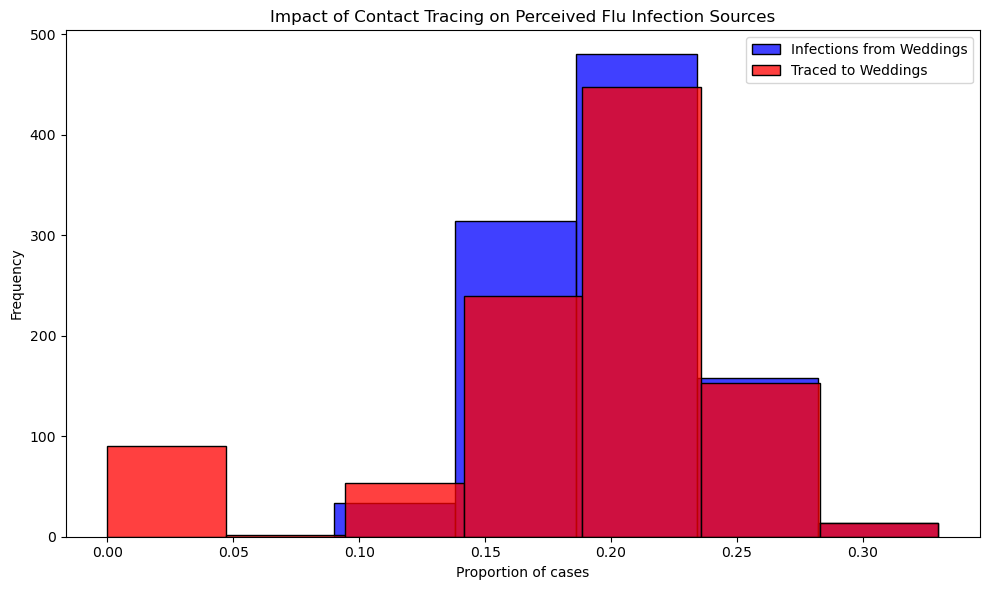

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

#seeded generator for full reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

def simulate_event(_=None):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': False,
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = rng.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True


  # Primary contact tracing: randomly decide which infected people get traced
  n_inf = ppl['infected'].sum()
  if n_inf > 0:
      ppl.loc[ppl['infected'], 'traced'] = rng.random(n_inf) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl.loc[ppl['traced'], 'event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['infected'] & ppl['event'].isin(events_traced), 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' or 'b'
  w_inf = (ppl['infected'] & (ppl['event_type'] == 'w')).sum()
  b_inf = (ppl['infected'] & (ppl['event_type'] == 'b')).sum()
  denom_inf = w_inf + b_inf
  p_wedding_infections = w_inf / denom_inf if denom_inf else np.nan

  w_tr = (ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w')).sum()
  b_tr = (ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b')).sum()
  denom_tr = w_tr + b_tr
  p_wedding_traces = w_tr / denom_tr if denom_tr else np.nan

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
R = 1000
results = [simulate_event(i) for i in range(R)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"]).dropna()

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 12/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
